In [78]:
!pip install tensorflow

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [81]:
#Downloading Datasets for A-Z Handwritten Data
dataset_url = 'https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format'

!pip install opendatasets
import opendatasets as od
od.download(dataset_url)

100%|██████████| 185M/185M [00:01<00:00, 101MB/s]


In [82]:

from tensorflow.keras.datasets import mnist

def load_mnist_dataset():

  # load data from tensorflow framework
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data() 

  # Stacking train data and test data to form single array named data
  data = np.vstack([trainData, testData]) 

  # Vertical stacking labels of train and test set
  labels = np.hstack([trainLabels, testLabels]) 

  # return a 2-tuple of the MNIST data and labels
  return (data, labels)

In [83]:
import numpy as np

def load_az_dataset(dataset_path):
    # initialize the list of data and labels
    data = []
    labels = []

    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(dataset_path):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")

        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and reshape them into a 28x28 matrix
        image = image.reshape((28, 28))

        # update the list of data and labels
        data.append(image)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")

        # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [84]:
#Loading Datasets
(digitsData, digitsLabels) = load_mnist_dataset()
dataset_path = "/content/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv"
(azData, azLabels) = load_az_dataset(dataset_path)

# Combining datasets
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

11501568/11490434 [==============================] - 0s 0us/step


In [85]:
len(azData)

372451

In [86]:
len(labels)

442451

In [87]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]

In [88]:
# the data for training and the remaining 20% for testing
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
#Performing Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

In [ ]:

#Building ResNet
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [ ]:
#Compiling model
EPOCHS = 40
INIT_LR = 1e-1
BS = 128

from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
(64, 64, 128, 256), reg=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
# Train the Network
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,class_weight=classWeight,
	verbose=1)

Epoch 1/40
2765/2765 [==============================] - 594s 213ms/step - loss: 1.4331 - accuracy: 0.8998 - val_loss: 0.5286 - val_accuracy: 0.8804
Epoch 2/40
2765/2765 [==============================] - 544s 197ms/step - loss: 0.9622 - accuracy: 0.9242 - val_loss: 0.4816 - val_accuracy: 0.9048
Epoch 3/40
2765/2765 [==============================] - 584s 211ms/step - loss: 0.8733 - accuracy: 0.9318 - val_loss: 0.6151 - val_accuracy: 0.8475
Epoch 4/40
2765/2765 [==============================] - 541s 196ms/step - loss: 0.8278 - accuracy: 0.9348 - val_loss: 0.4814 - val_accuracy: 0.9038
Epoch 5/40
2765/2765 [==============================] - 582s 210ms/step - loss: 0.7916 - accuracy: 0.9374 - val_loss: 0.5572 - val_accuracy: 0.8643
Epoch 6/40
2765/2765 [==============================] - 543s 196ms/step - loss: 0.7662 - accuracy: 0.9402 - val_loss: 0.5331 - val_accuracy: 0.8731
Epoch 7/40
2765/2765 [==============================] - 583s 211ms/step - loss: 0.7508 - accuracy: 0.9414 - val_

In [89]:
#Generating Classification Report
import pandas as pd
from sklearn.metrics import classification_report
labelNames = "0123456789"

labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

labelNames = [l for l in labelNames]

predictions = model.predict(testX, batch_size=BS)

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))


NameError: ignored

In [ ]:
#Saving the Model
model.save('OCR_Resnet.h5',save_format=".h5")


In [77]:
#Outpput
output = ""
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  output+=label
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
  images.append(image)
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)

NameError: ignored

##Model Deployment 

In [3]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2

In [59]:
loaded_model = load_model('/content/OCR_Resnet.h5')


In [ ]:
image = cv2.imread('/content/chars74k/English/Fnt/Sample010/img010-00376.png')

In [61]:
img = cv2.imread('/content/customer-images-for-site2.png',cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = cv2.bilateralFilter(gray, 13, 15, 15)
edged = cv2.Canny(gray, 30, 200) #Perform Edge detection
contours=cv2.findContours(edged.copy(),cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
cnts = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = None
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break
# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)
#Cropping Number plate
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

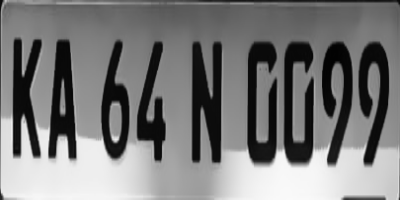

In [62]:
#img = cv2.resize(img,(500,300))
Cropped = cv2.resize(Cropped,(400,200))
from google.colab.patches import cv2_imshow
#cv2_imshow('car',img)
cv2_imshow(Cropped)

In [63]:
Cropped.dtype

dtype('uint8')

In [64]:
#Preprocessing Step
#Cropped = np.array(Cropped, dtype=np.uint8)
gray = cv2.bilateralFilter(Cropped, 13, 15, 15) 
#gray = cv2.cvtColor(Cropped, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

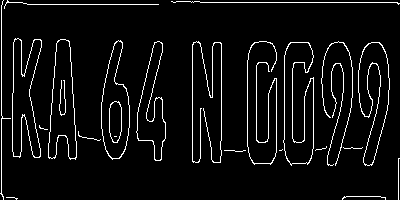

In [65]:
cv2_imshow(edged)
#cnts

In [66]:
chars = []

for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
   # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [67]:
len(chars)

4

In [68]:
gray = cv2.bilateralFilter(Cropped, 13, 15, 15)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
padded = cv2.copyMakeBorder(edged, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
padded = cv2.resize(padded, (32, 32))

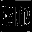

In [69]:
cv2_imshow(padded)


In [70]:
final_image=np.expand_dims(padded,axis=2)


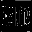

In [71]:
cv2_imshow(final_image)


In [72]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
#print(chars)
# OCR the characters using our handwriting recognition model
preds = loaded_model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

[INFO] 8 - 53.08%


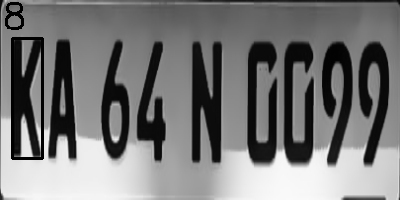

[INFO] 6 - 86.79%


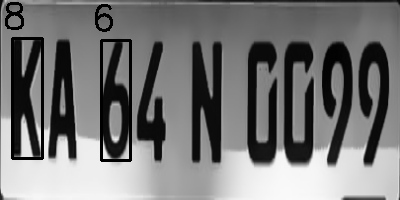

[INFO] 4 - 83.94%


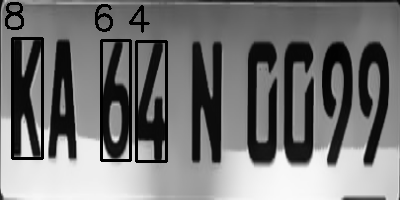

[INFO] 1 - 48.52%


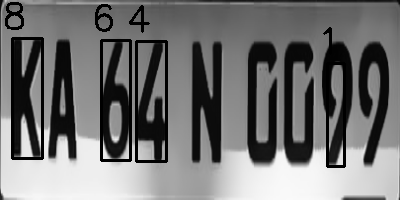

In [74]:
output=""
for (pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
  output+=label
  print("[INFO] {} - {:.2f}%".format(label, prob * 100))
  cv2.rectangle(Cropped, (x, y), (x + w, y + h), (0, 255, 0), 2)
  cv2.putText(Cropped, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
  cv2_imshow(Cropped)
  cv2.waitKey(0)

In [75]:
output

'8641'